# INSEE: Données carrroyées

Le carroyage consiste en un découpage du territoire français en carreaux de 200 mètres de côté. Ces carreaux s’affranchissent des limites communales ou départementales. Les informations qui sont diffusées à ce niveau sont récoltées par la Direction Générale des Finances Publiques (DGFIP). C’est cet organisme qui gère le cadastre et la collecte d’impôts, ces données sont donc exhaustives et fiables. Elles répondent à une norme européenne, la directive INSPIRE.

Les informations sont diffusées sur deux échelles. La première est le carreau. Une seule donnée est diffusée à cette échelle, la population qui habite dans le carreau. Les autres informations sont trop sensibles pour être diffusées au niveau d’un carreau qui ne contient, par exemple, qu’une seule personne. Les carreaux qui ne sont pas suffisamment peuplés sont donc regroupés en rectangles, ceux-ci doivent contenir au minimum 11 ménages.

Ces rectangles permettent de diffuser d’autres informations, tel que le nombre de ménages, la population par tranche d’âge (huit tranches), la taille des ménages, la surface cumulée des logements, le nombre de propriétaires, le nombre de personnes vivant en logement collectif ou encore la somme des revenus fiscaux. Certaines variables jugées comme sensibles, comme les revenus, sont traitées lorsqu’elles prennent des valeurs extrêmes.

<img src="https://www.geocible.com/images/divers/carreaux_exemple.png" alt="Drawing" style="width: 400px"/>

In [1]:
import pandas as pd
from tqdm import tqdm 
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
df_insee=pd.read_csv('/datastore/complexnet/jlevyabi/geoloc/final.csv')
import re;pat = re.compile(r'''(-*\d+\.\d+ -*\d+\.\d+);*''');new_geo=[]
for geo in tqdm(df_insee.geometry_y):
    matches = pat.findall(geo)
    if matches:
        lst = Polygon([tuple(map(float, m.split())) for m in matches])
    else:
        lst=None
    new_geo.append(lst)
#df_insee.geometry_y=new_geo

presentable_insee_df=df_insee.drop(["geometry","geometry_y","Unnamed: 0","idINSPIRE",
                                    "geometry_x","nbcar_x","id_x","id_y","idk"],axis=1)
#cent=presentable_insee_df.center
#lats=[float(x.split(',')[1][:-1]) for x in cent]
#lons=[float(x.split(',')[0][1:]) for x in cent]
#presentable_insee_df['lat']=lats;presentable_insee_df['lon']=lons
presentable_insee_df=presentable_insee_df.drop("center",axis=1)
presentable_insee_df=presentable_insee_df.convert_objects(convert_numeric=True)
inter= presentable_insee_df.astype(float).round(3)
presentable_insee_df =inter.dropna(how='any')
val_idx = inter.index.isin(presentable_insee_df.index)
presentable_insee_df['geometry']=[new_geo[it] for it,x in enumerate(val_idx) if x]

100%|██████████| 2278213/2278213 [01:14<00:00, 30663.78it/s]
/home/jlevyabi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/home/jlevyabi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
from bokeh.palettes import viridis, RdBu
from bokeh.models import ColorBar
from geopandas import GeoDataFrame

geo_insee=GeoDataFrame(presentable_insee_df)
geo_source = GeoJSONDataSource(geojson=geo_insee.to_json())

color_mapper = LinearColorMapper(RdBu[11])

fig = figure(title='Income')
fig.patches(xs='xs', ys='ys', alpha=0.9, source=geo_source, 
            color={'field': 'payment_type', 'transform': color_mapper}, 
            line_width=1, line_alpha=0.5, line_color='black')

hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=('<div><b>Borough</b>: @borough</div>'
              '<div><b>Zone</b>: @zone</div>'
              '<div><b>Cash Fraction</b>: @payment_type</div>')
)
fig.add_tools(hover)

color_bar = ColorBar(color_mapper=color_mapper, 
                     location=(0, 0), 
                     label_standoff=12)
fig.add_layout(color_bar, 'right')

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

figures['cash-fraction'] = fig

show(fig)

In [2]:
import matplotlib.pyplot as plt,seaborn as sns
plt.figure(figsize=(30,5))
import numpy as np
plt.subplot(131)
x=np.array(presentable_insee_df.ind_srf/presentable_insee_df.ind_r)
plt.hist(x,bins=50,histtype='bar', rwidth=0.8)
plt.title('Income Distribution v1')

plt.subplot(132)
sns.plt.scatter(df_insee.men,df_insee.ind_r,s=1)
sns.plt.xlabel('V2');sns.plt.ylabel('V1')

plt.subplot(133)
x=np.array(presentable_insee_df.ind_srf/presentable_insee_df.men)
plt.hist(x,bins=50,histtype='bar', rwidth=0.8)
plt.title('Income Distribution v2')
plt.show()



Aussi, pour comparer les niveaux de vie de ménages de taille ou de composition différente, on utilise une mesure du revenu corrigé par unité de consommation à l'aide d'une échelle d'équivalence. L'échelle actuellement la plus utilisée (dite de l'OCDE) retient la pondération suivante :
- 1 UC pour le premier adulte du ménage ;
- 0,5 UC pour les autres personnes de 14 ans ou plus ;
- 0,3 UC pour les enfants de moins de 14 ans.

Le niveau de vie est égal au revenu disponible du ménage divisé par le nombre d'unités de consommation (uc). Le niveau de vie est donc le même pour tous les individus d'un même ménage.
https://www.insee.fr/fr/metadonnees/definition/c1890


The main problem here is that we are not exactly given the annual income distribution which is equal to:
    $$X_{patch}=\frac{1}{N_{patch}}\sum_{i=0}^{N_{patch}}S_i \text{,with }S_i \text{ income of individual }i
    \text{ and } N_{patch}=\text{ # working individuals in patch }$$


What we are actually given corresponds to the annual income allotment per each member of a family given his age summed for all individuals of a given patch, corresponding to:
\begin{align}
S_{p}=\sum_{f \in p }\frac{S_{f}}{UC_{f}}\text{ with  }p\text{, patch and }f\text{, family.}\\
\\
\text{with }S_{f}=\sum_{i \in f} {S_{i}}\text{ with  }i\text{, working individual}
\end{align}

By replacing $UC_f$ by its expected value over the patch, we get:


\begin{align}
S_{p}=\mathbb{E}_f(\frac{1}{UC_{f}})\quad\sum_{f \in p }\sum_{i \in f} {S_i}=\mathbb{E}_f(\frac{1}{UC_f})\quad\sum_{i \in p }{S_i}\\
\text{with }i=\text{ individuals between age 25-65 and }\mathbb{E}_f(UC_{f})=\frac{UC_{p}}{\text{# family in patch}}
\end{align}

Therefore:
$$\boxed{X_{patch}=\frac{1}{N_{patch}}\frac{S_{patch}.UC_{patch}}{\text{# family in patch}}}$$

In [30]:
nb_menages=presentable_insee_df.men
nb_menages_unipers=presentable_insee_df.men_1ind
nb_menages_gt5=presentable_insee_df.men_5ind
nb_menages_2t5=nb_menages-nb_menages_unipers-nb_menages_gt5

people=presentable_insee_df.ind_r
children=presentable_insee_df.ind_age1+presentable_insee_df.ind_age2+presentable_insee_df.ind_age3+presentable_insee_df.ind_age4# From 
adults=people-children # SURE
adults_count_as_one=nb_menages_unipers+nb_menages_gt5+nb_menages_2t5 # 1 By menage SURE
adults_count_as_half=adults-adults_count_as_one # SURE

work_force=presentable_insee_df.ind_age6-presentable_insee_df.ind_age7

income_sum_by_uc=presentable_insee_df.ind_srf

uc=0.3*children+ 0.5*adults_count_as_half+adults_count_as_one
x=np.array(income_sum_by_uc*uc)/(nb_menages*work_force)

In [33]:
np.average(x,weights=nb_menages)

58362.38020278268

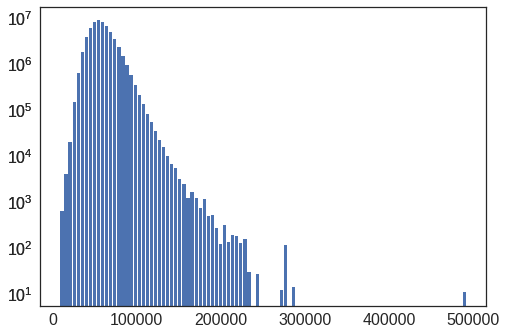

In [31]:
from matplotlib import ticker
#sns.plt.figure(figsize=(10,6))
fig, ax=plt.subplots()
sns.set(font_scale=1.6)  # crazy big
sns.set_style("white")
ax.hist(x_min,bins=100,weights=nb_menages,histtype='bar', rwidth=0.8,log=True)
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0,subs=(0.1,0.5,1.0, ), numticks=15))
#ax.xlabel('Approximative Income')
#ax.ylabel('Count')
plt.show()

In [45]:
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
ax.text(0.0, 0.1, "LogLocator(base=10, numticks=15)",
        fontsize=15, transform=ax.transAxes)


# INSEE: IRIS Data

L’IRIS (Ilot Regroupé pour l’Information Statistique), le maillage le plus fin pour la diffusion des données du recensement est massivement utilisé dans nos applications web et dans le géomarketing en général. Les données carroyées sont un peu plus confidentielles car l’information diffusée sur cette maille est moins complète. Mais elle peut être très utile pour l’implantation de points de ventes qui nécessitent une connaissance très précise du voisinage immédiat.

<img src="https://www.geocible.com/images/divers/iris_exemple.png" alt="Drawing" style="width: 400px"/>

In [11]:
import xlrd
import pandas as pd
def extract_xls_file(path,sheet_name,offset):
    workbook = xlrd.open_workbook(path)
    worksheet = workbook.sheet_by_name(sheet_name)
    rows = []
    for i, row in enumerate(range(worksheet.nrows)):
        if i <= offset:  # (Optionally) skip headers
            continue
        r = []
        for j, col in enumerate(range(worksheet.ncols)):
            r.append(worksheet.cell_value(i, j))
        rows.append(r)
    return(pd.DataFrame(rows[1:],columns=rows[0]))

f0="/datastore/complexnet/jlevyabi/geoloc/iris_opendata/RFDM2010IRI.xls"
d_exc=extract_xls_file(f0,"Distribution_Ménages",5)
f1="/datastore/complexnet/jlevyabi/geoloc/iris_opendata/BASE_TD_FILO_DISP_IRIS_2013.xls"
d_filo_disp_iris=extract_xls_file(f1,"IRIS_DISP",4)
f2="/datastore/complexnet/jlevyabi/geoloc/iris_opendata/BASE_TD_FILO_DEC_IRIS_2013.xls"
d_filo_dec_iris=extract_xls_file(f2,"IRIS_DEC",4)

In [12]:
d_filo_dec_iris.head()

,IRIS,LIBIRIS,COM,LIBCOM,DEC_PIMP13,DEC_TP6013,DEC_Q113,DEC_MED13,DEC_Q313,DEC_EQ13,...,DEC_D813,DEC_D913,DEC_RD13,DEC_S80S2013,DEC_GI13,DEC_PTSA13,DEC_PCHO13,DEC_PBEN13,DEC_PPEN13,DEC_PAUT13
0,010040101,Les Perouses-Triangle d'Activite,01004,Ambérieu-en-Bugey,51.5235,29.1009,10444.0,17736.0,24859.0,0.812754,...,26740.0,32582.0,6.67664,7.66924,0.338702,60.6,3.7,2.2,28.9,4.6
1,010040102,Longeray-Gare,01004,Ambérieu-en-Bugey,47.9592,36.1869,9110.0,15852.0,22860.0,0.867398,...,24802.0,30920.0,8.02283,8.78095,0.352724,63,4,2,27.8,3.2
2,010040201,Centre-St Germain-Vareilles,01004,Ambérieu-en-Bugey,56.7811,25.6579,11956.0,18608.0,25456.0,0.725494,...,27220.0,34642.0,5.01186,6.6062,0.332240,61.1,3.3,3.7,27.5,4.4
3,010040202,Tiret-Les Allymes,01004,Ambérieu-en-Bugey,68.7399,12.3286,16490.0,23162.0,30644.0,0.611087,...,32770.0,40858.0,3.71369,9.2253,0.470537,49.9,1.7,3.5,19.2,25.7
4,010330101,Coupy-Vanchy,01033,Bellegarde-sur-Valserine,45.679,28.9534,11392.0,18900.0,29294.0,0.947196,...,33352.0,44784.0,6.84352,8.02681,0.373058,69.5,3.9,1.6,21.9,3.1


100%|██████████| 50094/50094 [00:00<00:00, 89794.36it/s]
/home/jlevyabi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


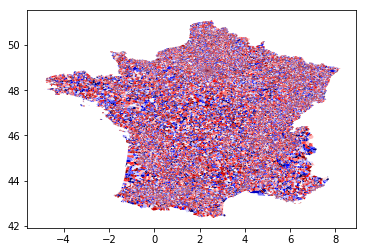

In [13]:
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm,numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

geo_file="/datastore/complexnet/jlevyabi/geoloc/iris_opendata/shapefile_iris/contours-iris-2016.geojson"
with open(geo_file) as f:
    arro_data=json.load(f)

df = gpd.read_file(geo_file)
codes=[];names=[]
france=Polygon([[-4.9658203125,42.3585439175],[8.4375,42.3585439175],
                [8.4375,51.2344073516],[-4.9658203125,51.2344073516],[-4.9658203125,42.3585439175]])
d_iris=df[[france.contains(geo_pt) if geo_pt else False for geo_pt in tqdm(df.geometry)]]
d_iris['IRIS']=d_iris.code_iris
#del d_iris['names_iris']
plt.figure(figsize=(25,15))
d_iris.plot(categorical=True,cmap='seismic')
plt.show()

In [21]:
dec_income_iris.head()

,iris,nom_iris,typ_iris,nom_region,insee_com,p12_pop,nom_com,code_dept,nom_dept,code_iris,...,DEC_D813,DEC_D913,DEC_RD13,DEC_S80S2013,DEC_GI13,DEC_PTSA13,DEC_PCHO13,DEC_PBEN13,DEC_PPEN13,DEC_PAUT13
0,0105,Ferdinand Buisson,H,HAUTE-NORMANDIE,76681,2966.614092,Sotteville-lès-Rouen,76,SEINE-MARITIME,766810105,...,22042.0,26900.0,11.7673,11.1695,0.366396,62,5.7,1,30.4,0.9
1,1503,Grandclément,H,RHONE-ALPES,69266,2561.999300,Villeurbanne,69,RHONE,692661503,...,30382.0,36468.0,6.21472,7.54432,0.330775,72.5,4,2.5,18.3,2.7
2,0104,Quartier 4,H,ILE-DE-FRANCE,78545,2185.436211,Saint-Cyr-l'École,78,YVELINES,785450104,...,33688.0,41208.0,4.68486,5.18523,0.296922,79.2,2.5,1.8,15.1,1.4
3,6916,Grandes Carrieres 16,H,ILE-DE-FRANCE,75118,2761.221544,Paris 18e Arrondissement,75,PARIS,751186916,...,41096.0,55188.0,8.7907,11.2906,0.404942,64.4,3.4,3.4,24,4.8
4,0109,Curie Zola Ouest,H,LORRAINE,54304,1885.005975,Laxou,54,MEURTHE-ET-MOSELLE,543040109,...,41186.0,55104.0,5.58185,7.29203,0.359443,55.4,1.8,6.5,30,6.3


/home/jlevyabi/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


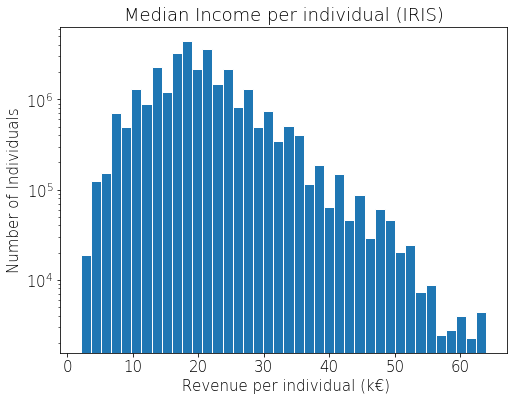

In [32]:
plt.figure(figsize=(8,6))

import matplotlib
dec_income_iris=pd.merge(d_iris, d_filo_dec_iris, on='IRIS')

font = {'family' : 'normal',
        'weight':"light",
        'size'   : 15}

matplotlib.rc('font', **font)
plt.hist(dec_income_iris.DEC_MED13//1000,bins=40,weights=dec_income_iris.p12_pop,
         edgecolor='white',histtype='bar',log=True)

plt.xlabel(" Revenue per individual (k€)",weight="light")
plt.ylabel('Number of Individuals',weight="light")
plt.title('Median Income per individual (IRIS)',weight="light")
plt.savefig("/datastore/complexnet/jlevyabi/ml_soc_econ/icdm18/income_per_indiv_iris.pdf")

plt.show()

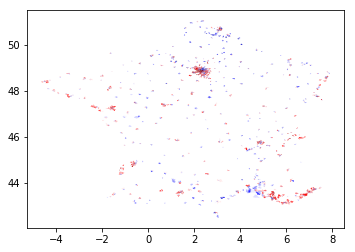

In [15]:
plt.figure(figsize=(40,40))
dec_income_iris.plot(column="DEC_MED13",categorical=True,cmap='seismic')
plt.show()

# Comparaison des deux sources

La source n’est pas la même, les informations diffusées à l’IRIS sont issues du recensement général de la population, alors que les données carroyées sont issues des déclarations d’impôts
Le recensement est effectué sur une partie de la population (environ 60% des ménages sont interrogés sur cinq ans) alors que les déclarations d’impôts sont remplies par la totalité des ménages.
Cette exhaustivité permet de diffuser les données collectées à un niveau plus fin. Il y a 50 200 IRIS en France métropolitaine, contre 2 275 000 carreaux. Un carreau contient donc en moyenne 28 personnes, contre 1 250 personnes pour un IRIS ou une commune non-divisée.
En revanche, l’information collectée lors de la déclaration d’impôts (et à plus forte raison l’information diffusée) est moins complète que pour le recensement. Un carreau contient 18 données socio-démographiques, contre 350 pour le recensement.



La population au carreau donne déjà une information essentielle pour l’implantation, par exemple, d’un commerce ou d’un service de proximité (une superette, une boulangerie, un coiffeur) dont la zone de chalandise ne dépasse généralement pas quelques rues. L’IRIS n’est donc déjà pas assez précise pour déterminer le potentiel de la zone, contrairement au carreau.

Si les autres informations diffusées sont moins complètes que pour les IRIS, elles permettent déjà de déterminer le profil du voisinage immédiat, et notamment son niveau de vie, une information essentielle pour l’implantation d’un commerce. Les personnes âgées propriétaires d’une maison peuvent également avoir des besoins différents que les jeunes locataires d’un petit studio, ou que les familles nombreuses vivant dans un grand logement.

Les informations contenues dans les données carroyées peuvent être complétées par d’autres données géolocalisées, comme par exemple les données issues du répertoire SIRENE. Ces dernières peuvent apporter des informations supplémentaires comme par exemple le nombre de salariés au lieu de travail, le nombre de commerce ou encore le nombre d’entreprises par code NAF agrégées au niveau du carreau.

# IRIS para home geolocalizaciones

In [ ]:
from geopandas import GeoDataFrame
from tqdm import tqdm_notebook as tqdm
import pickle
with open("d_mob_study_out.p", "rb") as f:
    d_mob_study_out = pickle.load(f)

geometry=[]
geo_real_home=[]
for usr,pos in tqdm(d_mob_study_out['new_dic_real_home'].items()):
    for single_pos in pos:
        geo_pt=Point(single_pos[1],single_pos[0])
        geo_real_home.append(usr)
        geometry.append(geo_pt)

df=pd.DataFrame(list(zip(geo_real_home,geometry)),columns=['usr','geometry'])
df=df.dropna(how='any')
gdf_real_home = GeoDataFrame(df,geometry=geometry)
from geopandas import sjoin
gdf_real_home.crs = dec_income_iris.crs
usrs_with_iris_income = sjoin(gdf_real_home, dec_income_iris, how="inner", op='within')
#usrs_with_iris_income.to_csv('/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/geo_real_home_iris.csv',
#                             sep='\t')

In [3]:
import pandas as pd
usrs_with_iris_income=pd.read_csv('/datastore/complexnet/jlevyabi/'
                             +'ml_soc_econ/data_files/UKSOC_rep/geo_real_home_iris.csv',
                               sep='\t')

In [4]:
usrs_with_iris_income=usrs_with_iris_income.drop(['Unnamed: 0','geometry'],axis=1)
#new_usrs_with_iris_income=usrs_with_iris_income.groupby(['usr']).agg(lambda x:x.value_counts().index[0])

# 200m INSEE para home geolocalizaciones

In [10]:
from geopandas import GeoDataFrame
import pickle
from tqdm import tqdm
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

with open("d_mob_study_out.p", "rb") as f:
    d_mob_study_out = pickle.load(f)
geometry=[]
geo_real_home=[]
for usr,pos in tqdm(d_mob_study_out['new_dic_real_home'].items()):
    for single_pos in pos:
        geo_pt=Point(single_pos[1],single_pos[0])
        geo_real_home.append(usr)
        geometry.append(geo_pt)
df=pd.DataFrame(list(zip(geo_real_home,geometry)),columns=['usr','geometry'])
df=df.dropna(how='any')
gdf_real_home = GeoDataFrame(df,geometry=geometry)

100%|██████████| 29677/29677 [00:27<00:00, 1068.83it/s]


In [51]:
from geopandas import sjoin
insee_income= GeoDataFrame(presentable_insee_df)
gdf_real_home.crs = insee_income.crs
usrs_with_insee_income = sjoin(gdf_real_home,insee_income, how="inner", op='within')

In [53]:
usrs_with_insee_income.to_csv('/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/geo_real_home_insee_200m.csv',
                             sep='\t')

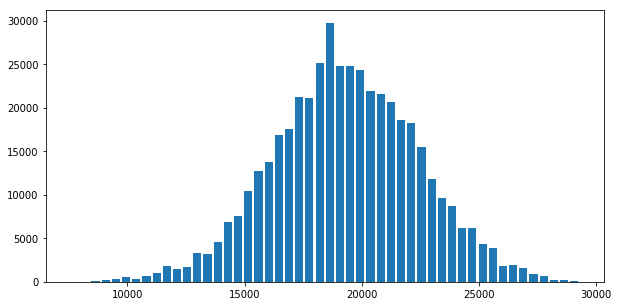

In [125]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.hist(usrs_with_insee_income.income,bins=50,histtype='bar', rwidth=0.8)
plt.show()

In [1]:
import pandas as pd
usrs_with_insee_income=pd.read_csv('/datastore/complexnet/jlevyabi/'
                                   +'ml_soc_econ/data_files/UKSOC_rep/geo_real_home_insee_200m.csv',
                             sep='\t')
usrs_with_iris_income=pd.read_csv('/datastore/complexnet/jlevyabi/'
                             +'ml_soc_econ/data_files/UKSOC_rep/geo_real_home_iris.csv',
                               sep='\t')

In [2]:
iris_data=usrs_with_iris_income.drop(['nom_iris','nom_region','nom_com','insee_com','index_right','iris','IRIS',
                                      'COM','code_iris','code_dept','insee_com',
                                      'nom_dept','typ_iris','LIBIRIS','LIBCOM'],
                                     axis=1).groupby('usr', as_index=False)["DEC_D113","DEC_MED13","DEC_D913"]
insee_200_data=usrs_with_insee_income.drop(["geometry","index_right"],
                                           axis=1).groupby('usr', as_index=False)['income']

get_max = lambda x: x.value_counts(dropna=True).index[0]
get_max.__name__ = "most frequent"

iris_data_avg=iris_data.mean()
iris_data_mode=iris_data.agg(get_max)
insee_200_data_avg=insee_200_data.mean()
insee_200_data_mode=insee_200_data.agg(get_max)

In [3]:
cor_sources_data_avg=pd.merge(iris_data_avg,insee_200_data_avg,on='usr',how='inner')
cor_sources_data_mode=pd.merge(iris_data_mode,insee_200_data_mode,on='usr',how='inner')

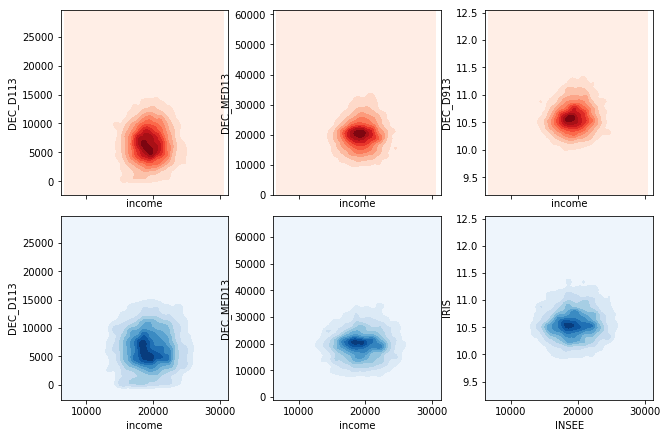

In [139]:
import seaborn as sns
import numpy as np
f, axes = plt.subplots(2, 3, figsize=(9,6), sharex=True)
plt.tight_layout()
x=cor_sources_data_avg.income
y=cor_sources_data_avg.DEC_D113
sns.kdeplot(x, y, cmap="Reds", shade=True, cut=5, ax=axes[0,0])
plt.xlabel('INSEE');plt.ylabel('IRIS')
y=cor_sources_data_avg.DEC_MED13
sns.kdeplot(x, y, cmap="Reds", shade=True, cut=5, ax=axes[0,1])
plt.xlabel('INSEE');plt.ylabel('IRIS')
y=cor_sources_data_avg.DEC_D913
sns.kdeplot(x, np.log(0.1+y), cmap="Reds", shade=True, cut=5, ax=axes[0,2])
plt.xlabel('INSEE');plt.ylabel('IRIS')

x=cor_sources_data_mode.income
y=cor_sources_data_mode.DEC_D113
sns.kdeplot(x, y, cmap="Blues", shade=True, cut=5, ax=axes[1,0])
plt.xlabel('INSEE');plt.ylabel('IRIS')
y=cor_sources_data_mode.DEC_MED13
sns.kdeplot(x, y, cmap="Blues", shade=True, cut=5, ax=axes[1,1])
plt.xlabel('INSEE');plt.ylabel('IRIS')
y=cor_sources_data_mode.DEC_D913
sns.kdeplot(x, np.log(0.1+y), cmap="Blues", shade=True, cut=5, ax=axes[1,2],)
plt.xlabel('INSEE');plt.ylabel('IRIS')
plt.show()

In [ ]:
sns.jointplot("total_bill", "DEC_D913", data=cor_sources_data_avg, kind="reg")

# Text

In [4]:
import gensim
import gensim.models.word2vec as w2v
from tqdm import tqdm
from gensim.models import Word2Vec
from gensim.similarities import MatrixSimilarity
from gensim.matutils import Dense2Corpus
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

Using TensorFlow backend.


In [5]:
import pickle
d_scales=pickle.load(open("spec_corrected_clusters.p","rb"))
d_only_pos=pickle.load(open("spec_corrected_clusters_only_pos_entries.p","rb"))
d_only_pos_non_an=pickle.load(open("spec_corrected_clusters_only_pos_entries_no_alphanum_filter.p","rb"))


In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30,7))
ax1 = plt.subplot(133)
ax1.set_title("Only positive similarity values (Not filter )")
plt.bar(range(len(d_only_pos_non_an)),[len(val) for val in list(d_only_pos_non_an.values())])
plt.xlabel('Cluster')
plt.ylabel('Nb Words')

ax1 = plt.subplot(132)
ax1.set_title("Only positive similarity values")
plt.bar(range(len(d_only_pos)),[len(val) for val in list(d_only_pos.values())])
plt.xlabel('Cluster')
plt.ylabel('Nb Words')

ax2 = plt.subplot(131)
ax2.set_title("Similarity values")
plt.bar(range(len(d_scales)),[len(val) for val in list(d_scales.values())])
plt.xlabel('Cluster')
plt.ylabel('Nb Words')
plt.show()

In [7]:
word2cluster_only_pos={word:cluster_nb
                     for cluster_nb,cluster_words in d_only_pos.items()
                     for word in cluster_words}
word2cluster_only_pos_non_an={word:cluster_nb
                     for cluster_nb,cluster_words in d_only_pos_non_an.items()
                     for word in cluster_words}


In [8]:
import pandas as pd
from tqdm import tqdm
f=open("/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/text_ses_net_approach/cleaned_full_info.txt","r")
data=[(line.split()[0],line.split()[1],line.split()[2]," ".join(line.split()[3:-2]))for line in tqdm(f.readlines())]
tweets=pd.DataFrame(data,columns=["id","sth","sth_class","tweet"])

100%|██████████| 13207699/13207699 [03:06<00:00, 70873.44it/s]


In [9]:
tweets_id=[int(idx) for idx in tweets.id];tweets["id"]=tweets_id
cors_id=[int(idx) for idx in cor_sources_data_avg.usr];cor_sources_data_avg["id"]=cors_id
cors_id=[int(idx) for idx in cor_sources_data_avg.usr];cor_sources_data_avg["id"]=cors_id
cors_id=[int(idx) for idx in cor_sources_data_mode.usr];cor_sources_data_mode["id"]=cors_id

In [10]:
usr_text=(tweets.groupby('id',squeeze=True,)['tweet'].apply(lambda x:
                                                            "%s" % ', '.join(x))).to_frame()

In [11]:
usr_text.head()

,tweet
id,
855,i m at mairie d issylesmoulineaux in issylesmo...
2071,", pissed of by entrepreneur not paying two dev..."
12726,having a crepe creperie du chateau
20203,i m at cimetiere militaire allemand in la camb...
30633,"bonjour et bienvenue, bienvenue aux 2200 fans ..."


In [12]:
import numpy as np
model = Word2Vec.load('/home/jlevyabi/seacabo/data_files/lowe_dim_sosweet2vec.w2v')
w2v_fts=[]
for tweet in tqdm(usr_text.tweet):
    inter=[model[word] for word in tweet.split() if word in model]
    if len(inter)==0:
        w2v_fts.append(None)
    else:
        w2v_fts.append(np.mean(inter,axis=0))
usr_text["avg_w2v"]=w2v_fts

100%|██████████| 103392/103392 [22:02<00:00, 78.16it/s] 


In [13]:
clust_freq_only_pos=[]
for tweet in tqdm(usr_text.tweet):
    clust_freq_only_pos.append((Counter([word2cluster_only_pos[word]
                                for word in tweet.split() if word in word2cluster_only_pos])))

cfd_only_pos=[{k:(v+0.0)/(sum(dic_count.values()))for k,v in dic_count.items()} 
            for dic_count in clust_freq_only_pos]

usr_text["cfd"]=[np.array(list({clus:(dic_count[clus] if clus in dic_count else 0)
                                 for clus in range(len(d_only_pos))}.values())) 
                          for dic_count in cfd_only_pos]

100%|██████████| 103392/103392 [01:54<00:00, 902.67it/s] 


In [14]:
clust_freq_only_pos_non_an=[]
for tweet in tqdm(usr_text.tweet):
    clust_freq_only_pos_non_an.append((Counter([word2cluster_only_pos_non_an[word]
                                for word in tweet.split() if word in word2cluster_only_pos_non_an])))

cfd_only_pos_non_an=[{k:(v+0.0)/(sum(dic_count.values()))for k,v in dic_count.items()} 
            for dic_count in clust_freq_only_pos_non_an]

usr_text["cfd_non_an"]=[np.array(list({clus:(dic_count[clus] if clus in dic_count else 0)
                                 for clus in range(len(d_only_pos_non_an))}.values())) 
                          for dic_count in cfd_only_pos_non_an]

100%|██████████| 103392/103392 [02:18<00:00, 746.03it/s] 


In [15]:
usr_text.reset_index(level=0, inplace=True)
#usr_text=usr_text.drop(["cfd_non_na"],axis=1)
usr_text.head()

,id,tweet,avg_w2v,cfd,cfd_non_an
0,855,i m at mairie d issylesmoulineaux in issylesmo...,"[-5.38151, -3.65578, -1.15666, -0.116351, -4.7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2071,", pissed of by entrepreneur not paying two dev...","[-1.40823, -0.290212, 0.967976, 0.972357, -0.7...","[0.00909090909091, 0.0, 0.0181818181818, 0.027...","[0.0, 0.0, 0.0, 0.0, 0.0363636363636, 0.0, 0.0..."
2,12726,having a crepe creperie du chateau,"[-2.67926, -2.02527, 0.410348, 0.722996, -2.97...","[0.0, 0.166666666667, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,20203,i m at cimetiere militaire allemand in la camb...,"[-4.83995, -4.51733, -0.154746, -1.63952, -3.3...","[0.0, 0.0, 0.0, 0.111111111111, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,30633,"bonjour et bienvenue, bienvenue aux 2200 fans ...","[0.629326, 3.28512, 3.9648, -0.255847, -0.3660...","[0.0, 0.0, 0.0, 0.0144927536232, 0.0, 0.014492...","[0.0, 0.0, 0.0, 0.0, 0.0434782608696, 0.0, 0.0..."


In [16]:
text_avg_inc=pd.merge(usr_text,cor_sources_data_avg,on="id",how="inner").drop("usr",axis=1)
text_mode_inc=pd.merge(usr_text,cor_sources_data_mode,on="id",how="inner").drop("usr",axis=1)

In [17]:
text_avg_inc.head()

,id,tweet,avg_w2v,cfd,cfd_non_an,DEC_D113,DEC_MED13,DEC_D913,income
0,754941,alors donc le parcours professionnel de valls ...,"[2.10147, 3.52182, 4.92579, -0.791319, 0.43843...","[0.00152207001522, 0.0, 0.0, 0.076103500761, 0...","[0.0, 0.0, 0.0, 0.00152207001522, 0.0060882800...",11446.000000,28002.000000,59866.000000,20793.497571
1,778339,on ne reste que quelques jours on reviendra pe...,"[0.739938, 2.97433, 3.24062, -1.02676, 0.46084...","[0.0, 0.0, 0.00384615384615, 0.0576923076923, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0038461538461...",8592.000000,23141.500000,53691.000000,24534.359500
2,956001,1 les consequences au lieu des causes et 2 ave...,"[2.01714, 3.44509, 4.4522, -0.427759, -0.36450...","[0.0177664974619, 0.0, 0.00253807106599, 0.035...","[0.0, 0.0, 0.00507614213198, 0.00253807106599,...",14266.285714,36719.142857,80995.714286,20612.713857
3,1044331,"joyeux anniversaire to max bautin, joyeux anni...","[1.1605, 2.63743, 3.61554, 0.33958, -1.78407, ...","[0.020618556701, 0.0, 0.0154639175258, 0.04639...","[0.0, 0.0, 0.00515463917526, 0.0, 0.0206185567...",11906.000000,38927.200000,97968.800000,20213.488833
4,1149311,"thank you, la suisse fait tourner et ça plane ...","[-0.70792, 0.54106, 2.0208, 0.392316, -1.1956,...","[0.0070564516129, 0.00100806451613, 0.02419354...","[0.0, 0.0, 0.00403225806452, 0.00302419354839,...",5762.000000,20278.444444,40612.000000,19395.606333


In [18]:
dim_total=150
text_avg_inc=text_avg_inc[text_avg_inc['avg_w2v'].isnull()== False]
text_fts_avg=np.vstack([np.hstack(sample.as_matrix()).reshape((1,dim_total)) 
                       for it,sample in (text_avg_inc[["avg_w2v","cfd"]].iterrows())])
targets_avg_insee200=np.array(text_avg_inc['income'])
targets_avg_iris_med=np.array(text_avg_inc['DEC_MED13'])
targets_avg_iris_low=np.array(text_avg_inc['DEC_D113'])
targets_avg_iris_high=np.array(text_avg_inc['DEC_D913'])

text_mode_inc=text_avg_inc[text_mode_inc['avg_w2v'].isnull()== False]
text_fts_mode=np.vstack([np.hstack(sample.as_matrix()).reshape((1,dim_total)) 
                       for it,sample in (text_mode_inc[["avg_w2v","cfd"]].iterrows())])
targets_mode_insee200=np.array(text_mode_inc['income'])
targets_mode_iris_med=np.array(text_mode_inc['DEC_MED13'])
targets_mode_iris_low=np.array(text_mode_inc['DEC_D113'])
targets_mode_iris_high=np.array(text_mode_inc['DEC_D913'])

/home/jlevyabi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
from sklearn import linear_model
reg = linear_model.BayesianRidge(verbose=True,n_iter=1000,normalize=True,fit_intercept=True)
reg.fit(text_fts_mode, targets_mode_iris_med)
from scipy.stats import pearsonr
print(pearsonr(reg.predict(text_fts_mode),text_fts_mode))

In [246]:
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.grid_search import GridSearchCV
import xgboost as xgb
xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6,10],
                    'n_estimators': [50,100,200]}, verbose=5, n_jobs=10, pre_dispatch=1)
clf.fit(text_fts_mode,targets_mode_iris_med)
clf.best_score_, clf.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[CV] max_depth=2, n_estimators=50 ....................................
[CV] ........... max_depth=2, n_estimators=50, score=0.070544 -   8.8s
[CV] max_depth=2, n_estimators=50 ....................................
[CV] ........... max_depth=2, n_estimators=50, score=0.055245 -  11.4s
[CV] max_depth=2, n_estimators=50 ....................................
[CV] ........... max_depth=2, n_estimators=50, score=0.052704 -   8.8s
[CV] max_depth=2, n_estimators=100 ...................................
[CV] .......... max_depth=2, n_estimators=100, score=0.087978 -  18.6s
[CV] max_depth=2, n_estimators=100 ...................................
[CV] .......... max_depth=2, n_estimators=100, score=0.058785 -  16.3s
[CV] max_depth=2, n_estimators=100 ...................................
[CV] .......... max_depth=2, n_estimators=100, score=0.056819 -  22.7s
[CV] max_depth=2, n_estimators=200 ...................................
[CV] .......... max_depth=2, n_estimators=200, score=0.093225 -  34.8s
[CV] m

[Parallel(n_jobs=10)]: Done  17 tasks      | elapsed:  8.6min


[CV] .......... max_depth=4, n_estimators=200, score=0.047165 - 1.4min
[CV] max_depth=6, n_estimators=50 ....................................
[CV] ........... max_depth=6, n_estimators=50, score=0.084766 -  32.7s
[CV] max_depth=6, n_estimators=50 ....................................
[CV] ........... max_depth=6, n_estimators=50, score=0.057333 -  36.3s
[CV] max_depth=6, n_estimators=50 ....................................
[CV] ........... max_depth=6, n_estimators=50, score=0.051760 -  30.7s
[CV] max_depth=6, n_estimators=100 ...................................
[CV] .......... max_depth=6, n_estimators=100, score=0.077593 - 1.1min
[CV] max_depth=6, n_estimators=100 ...................................
[CV] .......... max_depth=6, n_estimators=100, score=0.050172 -  59.5s
[CV] max_depth=6, n_estimators=100 ...................................
[CV] .......... max_depth=6, n_estimators=100, score=0.039622 -  54.1s
[CV] max_depth=6, n_estimators=200 ...................................
[CV] .

[Parallel(n_jobs=10)]: Done  36 out of  36 | elapsed: 38.1min finished


(0.06988174838698774, {'max_depth': 2, 'n_estimators': 200})

In [2]:
dic_topics={2:"Music",
4:"Computer Science",
11:"English",
12:"News",
13:"Games",
14:"Verbes gerondif -ant",
15: "Health Medicine",
16: "Verbs infinitive -er,ir",
17: "SportSoccer",
18: "Travels English",
19: "Catalan - Spanish Independence",
20: "News Religion-Violence",
21:"Movies",
23: "Personal Adjectives",
24: "Hashtags",
25: "Substantives",
26: "Verbs 3rd plural",
27: "Work More lower",
28: "Verbs Imparfait",
29: "Adjective Singular Feminine",
30: "Substitantives Soutenus",
31:"Arab",
32:"Turk",
33:"French Old Media ",
34: "Arab Names",
35: "Adjective Plural",
36: "Verbs 3rd singular",
37: "Verbs infinitive -er",
38: "English work",
39: "American English Media Personalities",
40: "Modern Music",
41: "Español",
43: "International News Middle East Centered" ,
44: "News/Political Adjective",
45: "Childish writing" ,
46: "Porn",
47: "French Places",
48: "Non Standard adjectives",
49: "Verbs 1st 2nd Plural",
50: "Soccer Players",
51:"English sport NBA UFC Ligue 1",
52:"Music related" ,
54:"Actresses",
55: "Tech",
56: "Sport Bike Tennis",
57: "Feminine Substantif",
58: "American TV Shows",
59: "Substantif Feminine Soutenu",
60: "English Adverbs",
61:"Verbs 2nd singular",
62:"Clothes",
63:"Africa",
64:"Tourism France",
65: "English Teens",
66: "Anime Teen Media Characters",
67: "French Soccer",
68: "French Politics",
70: "Portuguese Italian",
71:"Food",
72:"Poor Writing French",
74:"Critics Adjective soutenus",
75: "German",
76: "Soccer Hashtags",
78:" French Media",
79: "Poor abbreviations",
81:"Lyceens",
82:"English News",
83:"Poor Onomatopeyas",
85: "Voitures",
86: "Poor Verbs",
90: "Apps Tech",
94:"High Culture",
95: "Transportation",
96: "Arab_other",
97: "Descriptors",
99: "Games_other"}

potential_topics=["Arab","High Culture","Poor Onomatopeyas",
                  "Poor Writing French","Africa","Tech","Porn","Health Medicine"]


/home/jlevyabi/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


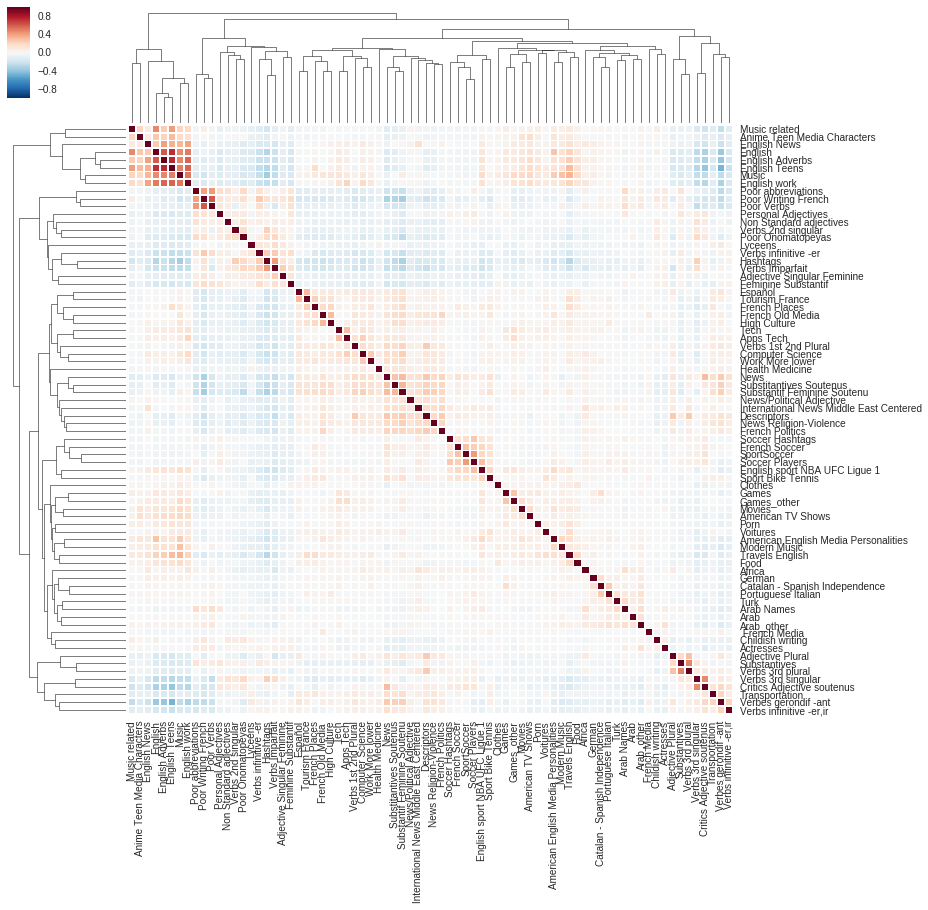

In [20]:
import pandas as pd
import seaborn as sns
sns.set()

idx_topics=[15,20,31,32,43,44,45,46,55,56,68,83,86,90,94,96]
topics=[dic_topics[t] for t in idx_topics]
pre_df_topic=text_fts_mode[:,50:]
df_topics=pd.DataFrame(pre_df_topic[:,list(dic_topics.keys())],columns=list(dic_topics.values()))

g=sns.clustermap(df_topics.corr(), center=0,
               linewidths=.75, figsize=(13, 13))
sns.plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
sns.plt.show()

In [21]:
inc_mode=text_mode_inc[["DEC_D113","DEC_MED13","DEC_D913","income"]]
inc_avg=text_avg_inc[["DEC_D113","DEC_MED13","DEC_D913","income"]]
ses_var="DEC_D913"
income_study={}

for topic in (potential_topics):
    no_topic_inc=inc_mode[list(df_topics[topic]==0)][ses_var]
    topic_inc=inc_mode[list(df_topics[topic]>0)][ses_var]
    income_study["no_"+topic]=np.array(no_topic_inc);income_study[topic]=np.array(topic_inc)

In [22]:
df_income_study=pd.DataFrame(data=list(income_study.values())).transpose()
df_income_study.columns=list(income_study.keys())

/home/jlevyabi/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/home/jlevyabi/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


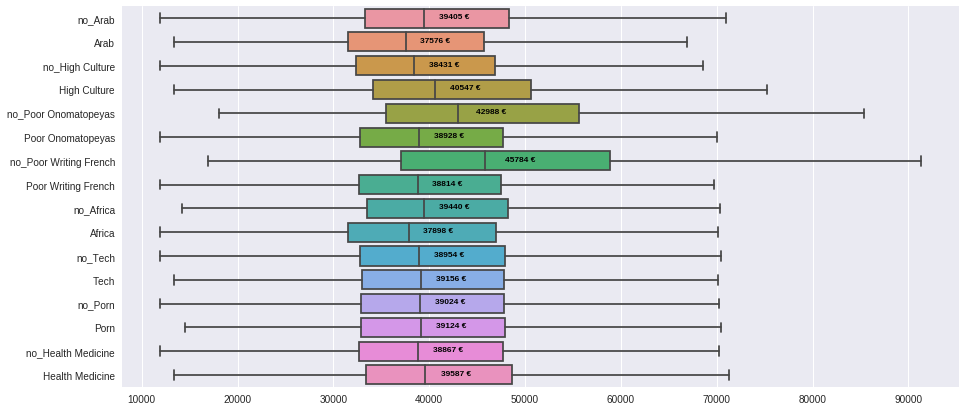

In [178]:
sns.plt.figure(figsize=(15,7))
import numpy as np
ax=sns.boxplot(df_income_study,orient="h",showfliers=False)
medians=df_income_study.median().values
median_labels = [str(int(s)) for s in medians]
pos = range(len(median_labels))
for tick,label in zip(pos,ax.get_yticklabels()):
    ax.text( medians[tick]*1.08,pos[tick], median_labels[tick]+" €", 
            horizontalalignment='center', size='small', color='k', weight='semibold')

In [1]:
import pickle
dic_to_save=pickle.load(open("/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/dic_all.p","rb"))

In [3]:
df_topics=dic_to_save["df_topics"]
inc_mode=dic_to_save["inc_mode"]

In [10]:
import matplotlib.pyplot as plt,pandas as pd,seaborn as sns
from tqdm import tqdm
uninteresting_topics=[24,25,26,27,28,29,35,36,37,49,50,61,57,62,64,97,99,95]
to_check=[dic_topics[x] for x in list(set(dic_topics.keys())-set(uninteresting_topics))]

ses_var="DEC_D913"


income_variation_with_topic=[]
for usr_it,inc_it in tqdm(zip(df_topics.iterrows(),inc_mode.iterrows())):
    usr,inc=usr_it[1],inc_it[1]
    for topic in to_check:
        if usr[topic]==0:
            pres_topic="No"
        else:
            pres_topic="Yes"
        income_variation_with_topic.append((inc[ses_var],topic,pres_topic))
df_income_variation_with_topic=pd.DataFrame(income_variation_with_topic,columns=[ses_var,"topic","present"])

/home/jlevyabi/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


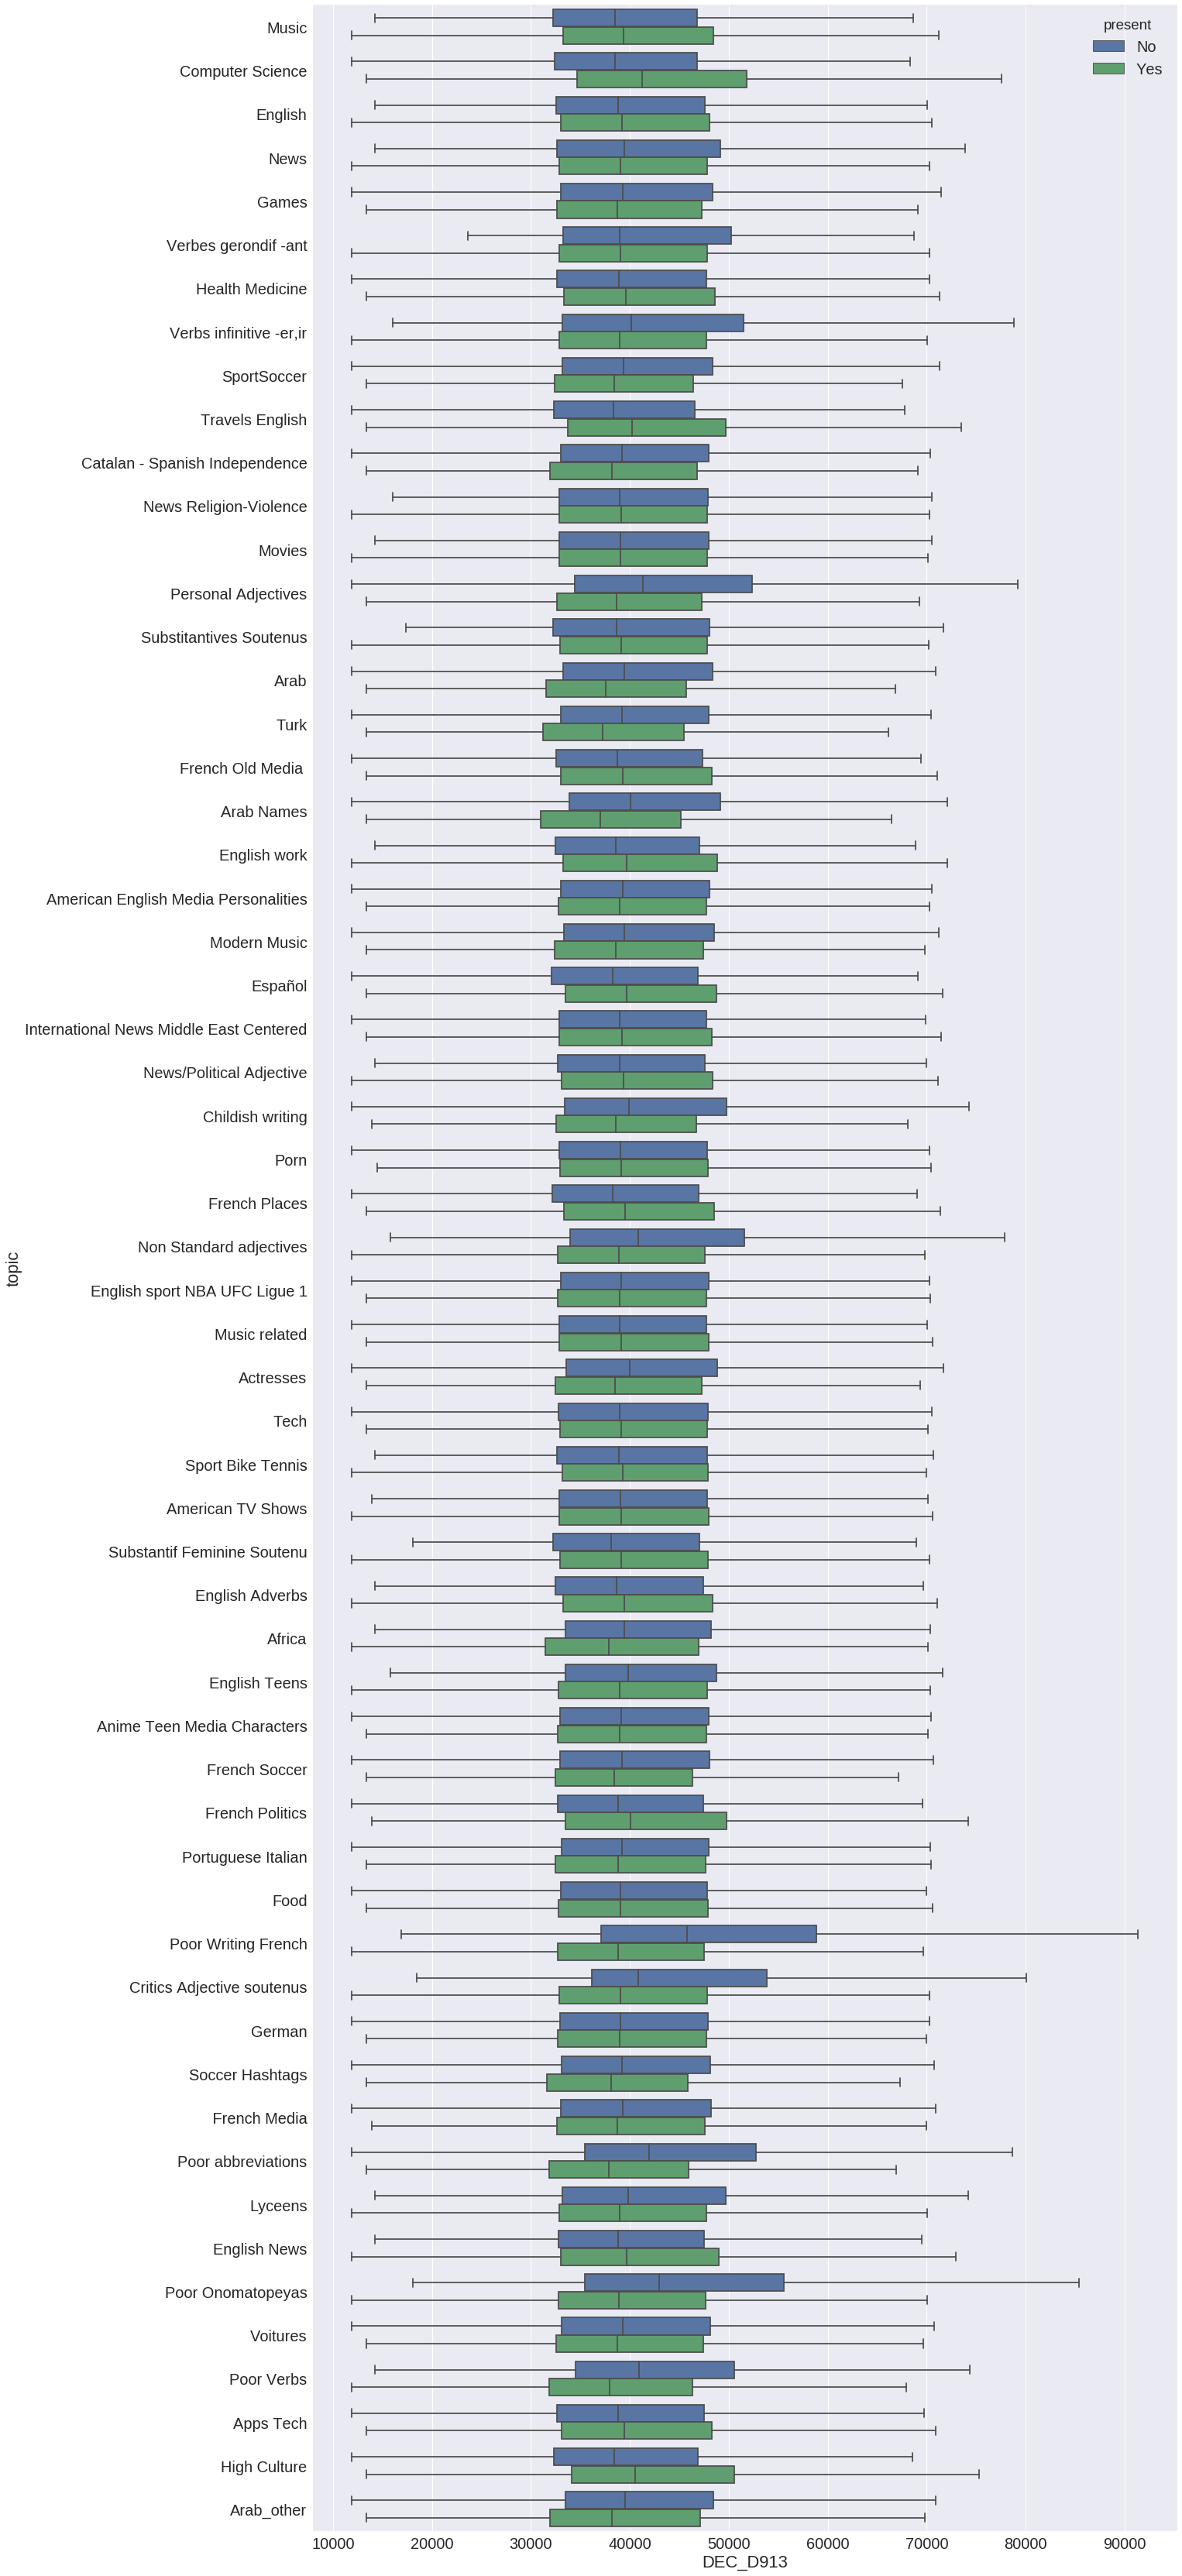

In [41]:
sns.plt.figure(figsize=(20,60))
sns.set(font_scale=2)  # crazy big
sns.boxplot(y="topic", x=ses_var, hue="present", data=df_vp,showfliers=False,orient="h")
sns.plt.show()


## Learning 

In [180]:
from sklearn import linear_model
from scipy.stats import pearsonr
from sklearn.model_selection import KFold, train_test_split
import random as rd
rd.seed(2)  
X_train, X_test, y_train, y_test=train_test_split(text_fts_mode
                                                  ,targets_mode_iris_high)
reg = linear_model.BayesianRidge(verbose=True,n_iter=1000,normalize=True,fit_intercept=True)
reg.fit(X_train, y_train)
print(pearsonr(reg.predict(X_test),y_test))

Convergence after  27  iterations
(0.32831581800448828, 2.7791358048006454e-128)


In [48]:
#svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)

In [29]:
import pickle
dic_fts={"features":text_fts_mode,"target_high_mode":targets_mode_iris_high,"target_high_avg":targets_avg_iris_high}
pickle.dump( dic_fts, open( "/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/feed_input_ml.p", "wb" ) )
#dic_fts=pickle.load(open( "/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/feed_input_ml.p","rb"))

In [121]:
#text_fts_mode=dic_fts["features"]
#targets_mode_iris_high=dic_fts["target_high_mode"]

nb_class=2
sorted_income=np.sort(targets_mode_iris_high)
N=len(sorted_income)
users_per_class=int(N/nb_class)
income_bins=[sorted_income[i*users_per_class] for i in range(nb_class)]
income_bins.append(max(sorted_income))
class_mode_iris_high=np.digitize(x=targets_mode_iris_high,bins=income_bins, right=False)
class_mode_iris_high[class_mode_iris_high==nb_class+1]=nb_class


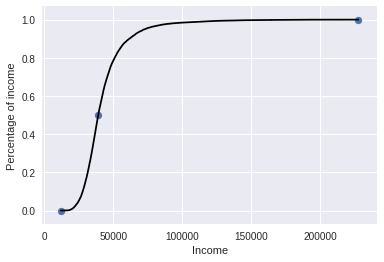

In [123]:
usr_frac = np.array(range(N))/float(N)
pts=np.linspace(start=0,stop=1,endpoint=True,num=nb_class+1)
plt.plot(sorted_income, usr_frac,color='k')
plt.scatter(income_bins,pts)
plt.xlabel('Income')
plt.ylabel('Percentage of income')
plt.show()

In [130]:
text_avg_inc.id.to_csv("/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/usrs_to_check.csv",sep="\t")

So far, joint study of text language and income
- I don't think that IRIS_DEC9113 allows to see at the individual level clearer SES differences than INSEE_200 data + allows the income estimation biais to be on the geographical data rather than the inference method (TO be checked: see how many different bins a single guy can fall in with insee and iris using the same method)
- Also, lower nb of points isn't affecting that much inference as most of users fall in the 13k patches covered by insee (not that many in the countryside)
- With text only the greatest feature seems to be the spectral clusters of the word similarity matrix. With these features and Bayesian Regression we get r=0.33 n regression and f1=0.6 in 2-class classification at most. In regression more complex methods (XGBoost and SVR) haven't improved the performance (maybe because parametrization is to be done more carefully athough some parameters in XGB have been studied)
- When combing with network information via the N2V embedding of users in the thresh_5_undirected network performance is still stuck at those values (2% improvement) for regression and classification while worst overall performances have been seen. Over all improved performace from the baseline classifier is still stuck at 12 % at most
- Shallow user features have not been tested but no jump in performance is to be expected

Things learned:
- Stick with 2 class classification problem
- Text is main feature on which to invest fine-tuning efforts
- Network embedding has yet to show its usefulness

Things to be tried:
- Filter users based on the topic of conversation: If a guy is only talking about soccer in a very common way this might be hindering results __TOPIC FILTERING__
- 2 things to be seen: cos similarity distance and income difference between  users + SSL on network if first experiment tells anything. If SSL, weight predictions with previous inferences: __GO TO NETWORK SECTION__
- Improve more filtering procedure: we are 20k users. Lampos et al. got 1.2k, we can still lower the bar on the acceptable sample size!! 
- Maybe filter out also users from the middle class to see some difference
- We still need to verify whether income association methods are valid: When running same inference methods on data with INSEE and IRIS association totally different results !!! (Linkedin data)


# NETWORK

In [23]:
f_embed="/datastore/complexnet/jlevyabi/network_representation/data_files/network_files/embeddings/node2vec.emb"
with open(f_embed, 'r') as f:
    first_line = f.readline()
f.close()
dim_embed=int(first_line.split()[1])

net_cols=["dim_"+str(i) for i in range(dim_embed)]

network_emb=pd.read_csv(sep=" ",skiprows=[0],names=["id"]+net_cols,
    filepath_or_buffer=f_embed,)
usr_embed=np.array(network_emb[net_cols])
network_emb["n2v"]=[line for line in usr_embed]
network_emb=network_emb[["id","n2v"]]

In [24]:
df_net_txt_inc=pd.merge(text_mode_inc,network_emb,on="id",how="inner")
df_net_txt_inc.head(1)

,id,tweet,avg_w2v,cfd,cfd_non_an,DEC_D113,DEC_MED13,DEC_D913,income,n2v
0,754941,alors donc le parcours professionnel de valls ...,"[2.10147, 3.52182, 4.92579, -0.791319, 0.43843...","[0.00152207001522, 0.0, 0.0, 0.076103500761, 0...","[0.0, 0.0, 0.0, 0.00152207001522, 0.0060882800...",11446.0,28002.0,59866.0,20793.497571,"[-0.475505, 0.043126, -0.092306, -0.415472, -0..."


In [25]:
dim_total_net=200
net_text_fts_mode=np.vstack([np.hstack(sample.as_matrix()).reshape((1,dim_total_net)) 
                       for it,sample in (df_net_txt_inc[["avg_w2v","cfd","n2v"]].iterrows())])
targets_mode_iris_high_net=np.array(df_net_txt_inc['DEC_D913'])

In [26]:
from sklearn import linear_model
from scipy.stats import pearsonr
from sklearn.model_selection import KFold, train_test_split
import random as rd
rd.seed(2)
X_train, X_test, y_train, y_test=train_test_split(net_text_fts_mode,targets_mode_iris_high_net)
reg = linear_model.BayesianRidge(verbose=True,n_iter=1000,normalize=True,fit_intercept=True)
reg.fit(X_train, y_train)
print(pearsonr(reg.predict(X_test),y_test))

Convergence after  23  iterations
(0.37925701907681358, 3.4807108926079966e-87)


In [176]:
#text_fts_mode=dic_fts["features"]
#targets_mode_iris_high=dic_fts["target_high_mode"]

nb_class=2
sorted_income=np.sort(targets_mode_iris_high_net)
N=len(sorted_income)
users_per_class=int(N/nb_class)
income_bins=[sorted_income[i*users_per_class] for i in range(nb_class)]
income_bins.append(max(sorted_income))
class_mode_iris_high=np.digitize(x=targets_mode_iris_high_net,bins=income_bins, right=False)
class_mode_iris_high[class_mode_iris_high==nb_class+1]=nb_class


import pickle
dic_fts={"features":net_text_fts_mode,"target_high_mode":class_mode_iris_high}

pickle.dump( dic_fts, open( "/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/feed_input_ml_with_net.p", "wb" ) )
#dic_fts=pickle.load(open( "/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/feed_input_ml.p","rb"))

In [27]:
from sklearn.metrics import pairwise_distances as emb_dist
from sklearn.metrics.pairwise import pairwise_distances as inc_dist


def embed_income(simil_fun,emb_data,inc_data,nb_j=10):
    nb_users=len(inc_data)
    similarities=np.triu(emb_dist(emb_data,metric=simil_fun),k=1)
    income_diff=np.triu(inc_dist(inc_data.reshape(-1, 1),n_jobs=nb_j),1)
    return [(similarities[i,j],income_diff[i,j]) for i in range(nb_users-1) for j in range(i+1,nb_users)]

def get_embedding(embed_name,df):
    dim_total=len((df.head(1)[embed_name].as_matrix())[0])
    return np.array(np.vstack([np.hstack(sample.as_matrix()).reshape((1,dim_total))
                      for it,sample in (df[[embed_name]].iterrows())]))
    

In [28]:
sample_df_net_txt_inc=df_net_txt_inc.sample(500)
n2v_inc_DEC_D913=embed_income("euclidean",get_embedding("n2v",sample_df_net_txt_inc),
                              np.array(sample_df_net_txt_inc["DEC_D913"]))
w2v_inc_DEC_D913=embed_income("cosine",get_embedding("avg_w2v",sample_df_net_txt_inc),
                              np.array(sample_df_net_txt_inc["DEC_D913"]))
cfd_inc_DEC_D913=embed_income("euclidean",get_embedding("cfd",sample_df_net_txt_inc),
                              np.array(sample_df_net_txt_inc["DEC_D913"]))

In [29]:
dic_plot={0:n2v_inc_DEC_D913,1:w2v_inc_DEC_D913,2:cfd_inc_DEC_D913}
dic_legend={0:"n2v_euc_distance",1:"w2v_cos_dist",2:"cfd_cos_dist"}

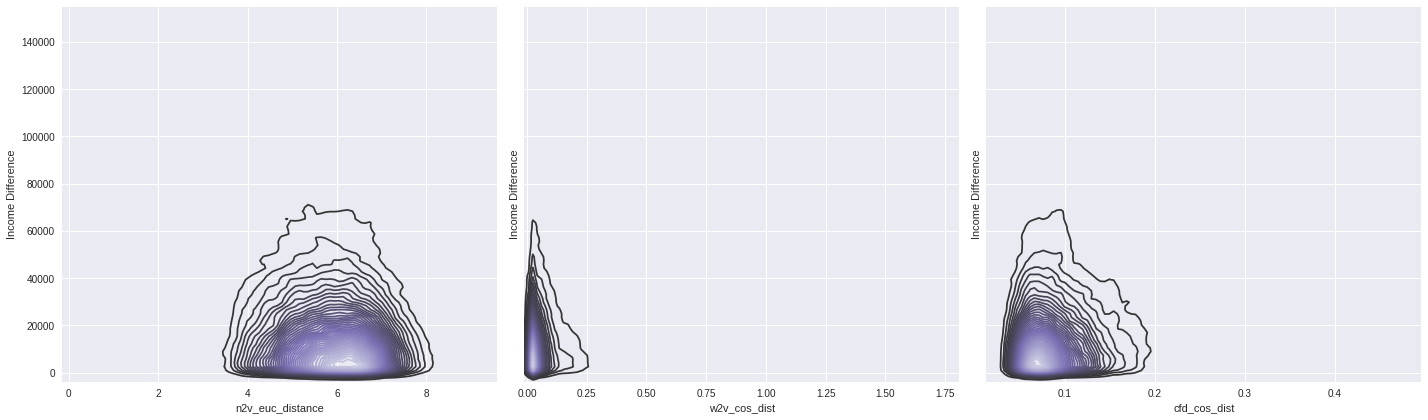

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
f, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=False, sharey=True)
# Rotate the starting point around the cubehelix hue circle
for i,ax in enumerate(axes.flat):
    data=np.array(dic_plot[i])
    sns.kdeplot(data[:,0], data[:,1], n_levels=50, cmap="Purples_d",ax=ax)
    ax.set_xlabel(dic_legend[i])
    ax.set_ylabel("Income Difference")
f.tight_layout()

In [35]:
dic_to_save={
    "cfd_inc_DEC_D913":cfd_inc_DEC_D913,
    "cfd_only_pos":cfd_only_pos,
    "cfd_only_pos_non_an":cfd_only_pos_non_an,
    "cor_sources_data_avg":cor_sources_data_avg,
    "cor_sources_data_mode":cor_sources_data_mode,
    "cors_id":cors_id,
    "df_income_study":df_income_study,
    "df_net_txt_inc":df_net_txt_inc,
    "df_topics":df_topics,
    "inc_avg":inc_avg,
    "inc_mode":inc_mode,
    "insee_200_data":insee_200_data,
    "insee_200_data_avg":insee_200_data_avg,
    "insee_200_data_mode":insee_200_data_mode,
    "iris_data_avg":iris_data_avg,
    "iris_data_mode":iris_data_mode,
    "net_text_fts_mode":net_text_fts_mode,
    "network_emb":network_emb,
    "n2v_inc_DEC_D913":n2v_inc_DEC_D913,
    "targets_avg_insee200":targets_avg_insee200,
    "targets_avg_iris_high":targets_avg_iris_high,
    "targets_avg_iris_low":targets_avg_iris_low,
    "targets_avg_iris_med":targets_avg_iris_med,
    "targets_mode_insee200":targets_mode_insee200,
    "targets_mode_iris_high":targets_mode_iris_high,
    "targets_mode_iris_high_net":targets_mode_iris_high_net,
    "targets_mode_iris_low":targets_mode_iris_low,
    "targets_mode_iris_med":targets_mode_iris_med,
    "text_avg_inc":text_avg_inc,
    "text_fts_avg":text_fts_avg,
    "text_fts_mode":text_fts_mode,
    "text_mode_inc":text_mode_inc,
    "tweets":tweets,
    "usr_embed":usr_embed,
    "usr_text":usr_text,
    "usrs_with_insee_income":usrs_with_insee_income,
    "usrs_with_iris_income":a,
    "w2v_fts":w2v_fts,
    "w2v_inc_DEC_D913":w2v_inc_DEC_D913,
    "word2cluster_only_pos":word2cluster_only_pos,
    "word2cluster_only_pos_non_an":word2cluster_only_pos_non_an
}

In [37]:
import pickle
pickle.dump(dic_to_save,open("/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/dic_all.p","wb"))

In [11]:
import pickle
d=pickle.load(open("/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/dic_all.p","rb"))
new_dic_real_home_filter_the_filter=pickle.load(open( "new_dic_real_home_max_filtered.p", "rb" ))

In [19]:
(list(new_dic_real_home_filter_the_filter.keys())[0])

459667002

In [24]:
#df_net_txt_inc=d["df_net_txt_inc"]
df_t_last_filter=df_net_txt_inc[[x in list(new_dic_real_home_filter_the_filter.keys()) for x in df_net_txt_inc.id ]]
df_t_last_filter.head()

,id,tweet,avg_w2v,cfd,cfd_non_an,DEC_D113,DEC_MED13,DEC_D913,income,n2v
2,1149311,"thank you, la suisse fait tourner et ça plane ...","[-0.70792, 0.54106, 2.0208, 0.392316, -1.1956,...","[0.0070564516129, 0.00100806451613, 0.02419354...","[0.0, 0.0, 0.00403225806452, 0.00302419354839,...",5762.0,20278.444444,40612.000000,19395.606333,"[-0.956629, -0.360282, -0.434334, -0.91881, -0..."
3,1487491,en attendant la premiere reunion de la journee...,"[1.91144, 2.94258, 4.16956, 0.158279, -0.84143...","[0.0110785272076, 0.000325839035516, 0.0101010...","[0.0, 0.0, 0.000325839035516, 0.0, 0.014988595...",11906.0,25528.000000,50266.000000,22582.667000,"[0.389582, 0.168004, 0.204709, -0.37344, -0.88..."
4,1491601,Ça fait bientot 10ans que je n avais pas attac...,"[0.45849, 1.60462, 2.84178, 0.197326, -0.46367...","[0.0066889632107, 0.0066889632107, 0.056856187...","[0.0, 0.0, 0.0, 0.0, 0.00334448160535, 0.0, 0....",8614.0,32638.666667,69964.333333,21409.591667,"[0.181676, 0.747708, -0.502433, -1.745875, -0...."
21,6265892,"c est parti, mouhaha, photo de presse du proch...","[-0.0748491, 0.533639, 1.73441, 0.172886, -0.8...","[0.00284360189573, 0.00379146919431, 0.0227488...","[0.0, 0.0, 0.000947867298578, 0.00189573459716...",8888.0,21616.000000,38542.000000,18685.741000,"[0.519449, -0.031874, 0.043654, -1.19797, -0.4..."
31,6981912,"au revoir leon mercadet – igttele via, comment...","[1.88071, 3.13868, 4.5322, -0.490883, -0.20727...","[0.00373134328358, 0.0, 0.00373134328358, 0.05...","[0.0, 0.0, 0.0, 0.00186567164179, 0.0149253731...",9854.0,37403.000000,107636.000000,24706.304000,"[-0.577113, 0.452127, 0.249684, -0.963922, -0...."


In [25]:
df_t_last_filter.shape

(2746, 10)

In [29]:
import numpy as np
dim_total_net=200
net_text_fts_mode=np.vstack([np.hstack(sample.as_matrix()).reshape((1,dim_total_net)) 
                       for it,sample in (df_t_last_filter[["avg_w2v","cfd","n2v"]].iterrows())])
targets_mode_iris_high_net=np.array(df_t_last_filter['DEC_D913'])

In [35]:
from sklearn import linear_model
from scipy.stats import pearsonr
from sklearn.model_selection import KFold, train_test_split
import random as rd
rd.seed(0)
X_train, X_test, y_train, y_test=train_test_split(net_text_fts_mode,targets_mode_iris_high_net)
reg = linear_model.BayesianRidge(verbose=True,n_iter=1000,normalize=False,fit_intercept=True)
reg.fit(X_train, y_train)
print(pearsonr(reg.predict(X_test),y_test))

Convergence after  26  iterations
(0.28655605624238034, 1.8836974541089376e-14)


# TOPIC FILTERING

In [38]:
cfd_study=get_embedding("cfd",text_mode_inc)

In [39]:
cfd_study[0,:]

array([ 0.00152207,  0.        ,  0.        ,  0.0761035 ,  0.00152207,
        0.00456621,  0.        ,  0.02587519,  0.00304414,  0.00761035,
        0.00761035,  0.00152207,  0.02435312,  0.        ,  0.14459665,
        0.        ,  0.01674277,  0.        ,  0.        ,  0.        ,
        0.01065449,  0.        ,  0.        ,  0.00456621,  0.1826484 ,
        0.00456621,  0.00456621,  0.00456621,  0.01826484,  0.00608828,
        0.00913242,  0.        ,  0.        ,  0.        ,  0.        ,
        0.0152207 ,  0.02283105,  0.00761035,  0.00152207,  0.        ,
        0.        ,  0.00152207,  0.        ,  0.        ,  0.        ,
        0.        ,  0.00152207,  0.00304414,  0.00152207,  0.00304414,
        0.        ,  0.00152207,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.02283105,  0.        ,  0.02891933,
        0.        ,  0.00456621,  0.        ,  0.00152207,  0.00456621,
        0.00152207,  0.00152207,  0.        ,  0.00152207,  0.01

In [ ]:
inc_mode=text_mode_inc[["DEC_D113","DEC_MED13","DEC_D913","income"]]
inc_avg=text_avg_inc[["DEC_D113","DEC_MED13","DEC_D913","income"]]
ses_var="DEC_D913"
income_study={}

for topic in (potential_topics):
    no_topic_inc=inc_mode[list(df_topics[topic]==0)][ses_var]
    topic_inc=inc_mode[list(df_topics[topic]>0)][ses_var]
    income_study["no_"+topic]=np.array(no_topic_inc);income_study[topic]=np.array(topic_inc)

In [ ]:
df_income_study=pd.DataFrame(data=list(income_study.values())).transpose()
df_income_study.columns=list(income_study.keys())

In [ ]:
sns.plt.figure(figsize=(15,7))
import numpy as np
ax=sns.boxplot(df_income_study,orient="h",showfliers=False)
medians=df_income_study.median().values
median_labels = [str(int(s)) for s in medians]
pos = range(len(median_labels))
for tick,label in zip(pos,ax.get_yticklabels()):
    ax.text( medians[tick]*1.08,pos[tick], median_labels[tick]+" €", 
            horizontalalignment='center', size='small', color='k', weight='semibold')

/home/jlevyabi/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


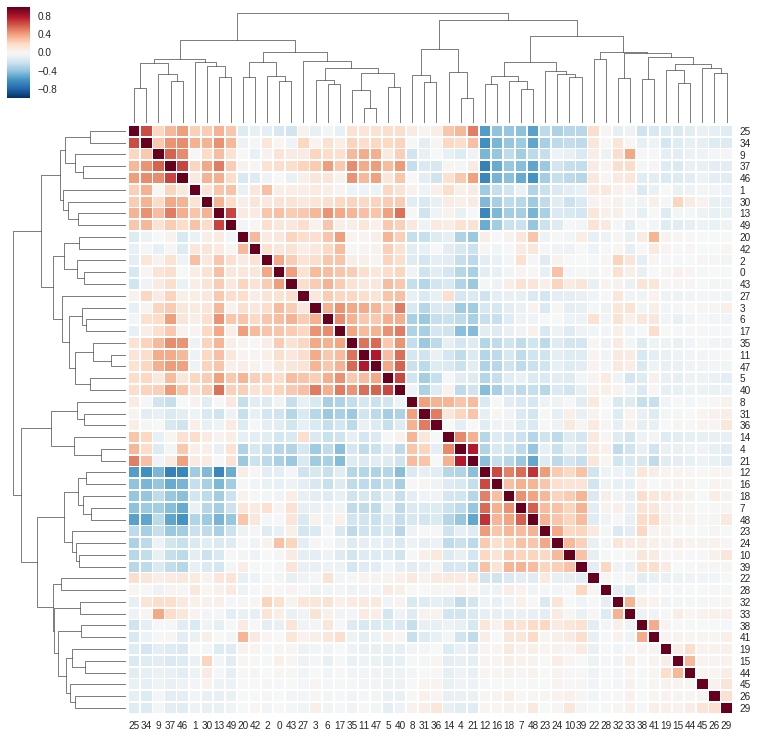

NameError: name 'i' is not defined

In [6]:
import pandas as pd
from tqdm import tqdm
f=open("/home/jlevyabi/seacabo/data_files/non_empty_undir_network_thresh_5_ids_body.txt","r")
data=[(line.split('\t')[0],line.split('\t')[1].replace('\n','')) for line in tqdm(f.readlines())]
tweets=pd.DataFrame(data,columns=["id","tweet"])374bc8427fc9f75a356984a4d603c934d857748488754943
tweets_id=[int(idx) for idx in tweets.id];tweets["id"]=tweets_id
usr_text=(tweets.groupby('id',squeeze=True,)['tweet'].apply(lambda x:"%s" % ' '.join(x))).to_frame()

import pickle
d100=pickle.load(open("/local/jlevyabitb/ml_soc_econ/python_scripts/spec_corrected_clusters_only_pos_entries_50.p","rb"))
import numpy as np
from collections import Counter

def get_cluster_info(dic_clus,df_tweets):
    nb_clusters=len(list(dic_clus.keys()))
    word2cluster_only_pos={word:cluster_nb for cluster_nb,cluster_words in dic_clus.items() for word in cluster_words}
    clust_freq_only_pos=[]
    for tweet in tqdm(df_tweets.tweet):
        clust_freq_only_pos.append((Counter([word2cluster_only_pos[word]
                                             for word in tweet.split() if word in word2cluster_only_pos])))
    cfd_only_pos=[{k:(v+0.0)/(sum(dic_count.values()))for k,v in dic_count.items()}
                  for dic_count in clust_freq_only_pos]
    df_tweets["cfd_%d"%nb_clusters]=[np.array(list({clus:(dic_count[clus] if clus in dic_count else 0)
                                    for clus in range(len(dic_clus))}.values())) for dic_count in cfd_only_pos]
    return (df_tweets)

def get_embedding(embed_name,df):
    dim_total=len((df.head(1)[embed_name].as_matrix())[0])
    return np.array(np.vstack([np.hstack(sample.as_matrix()).reshape((1,dim_total))for it,sample in (df[[embed_name]].iterrows())]))

usr_text=get_cluster_info(d100,usr_text)

import pandas as pd
import seaborn as sns
sns.set()
df_topics=get_embedding("cfd_50",usr_text)
df_topics=pd.DataFrame(df_topics)
df_topics=df_topics.loc[:, (df_topics != df_topics.iloc[0]).any()] # remove constant rows
corr_df=df_topics.corr().dropna(how='all')
g=sns.clustermap(df_topics.corr(), center=0,
               linewidths=.75, figsize=(13, 13))
sns.plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
sns.plt.show()

dic_topics={0:"Economy",1:"Food",2:"Music",3:"Feminine Adjective (Sing)",4:"Technology",5:"Animals",
            6:"Consumption Items",7:"Feminine Adjective (Plur)",8:"Formal Substantives",9:"Informal",
            10: "Formal Verbs",11:"English Verbs",12:"News Substantives",13:"Gaming",14:"Gerund",
           15:"Health/Medicine",16:"Formal Infinitive",17:"Soccer Names",18:"Travel",19:"Catalan",
           20:"Politcal/Societal News",21:"Cinema",22:"Regular Verbs",23:"Insults",24:"Hashtags",
           25:"Male Adjectives",26:"Verbs (3rd plural)",27:"Jobs",28:"Futur/Past Verbs",29:"",
           30:"Politics",31:"Short Informal Expressions",32:"Turk",33:"Author Names",34:"Arab Names",
           35:"Formal Adjectives",36:"",37:"Informal Infinitive",38:"Tech Journalism",39:"Media Personnalities",
           40:"Pop Culture Singers",41:""}

potential_topics=["Arab","High Culture","Poor Onomatopeyas",
                  "Poor Writing French","Africa","Tech","Porn","Health Medicine"]



i
import pandas as pd
import seaborn as sns
sns.set()
df_topics=get_embedding("cfd_100",usr_text)
df_topics=pd.DataFrame(df_topics)
df_topics=df_topics.loc[:, (df_topics != df_topics.iloc[0]).any()] # remove constant rows
corr_df=df_topics.corr().dropna(how='all')
g=sns.clustermap(df_topics.corr(), center=0,
               linewidths=.75, figsize=(13, 13))
sns.plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
sns.plt.show()
